In [55]:
library(dplyr)      |> suppressPackageStartupMessages()
library(readr)      |> suppressPackageStartupMessages()
library(bnlearn)    |> suppressPackageStartupMessages()
library(bnstruct)   |> suppressPackageStartupMessages()
library(Rgraphviz)  |> suppressPackageStartupMessages()
library(foreach)    |> suppressPackageStartupMessages()
library(doParallel) |> suppressPackageStartupMessages()

In [56]:
learning <- function (data, maxParent, algo = "k2", percentage = 1, plot = F) {
    # Check if the percentage is within the valid range
    if (percentage < 0 || percentage > 1) {
        stop("Percentage must be between 0 and 1.")
    }

    # Subset the data based on the given percentage
    # Shuffle the rows of the data randomly
    num_rows <- nrow(data)
    data <- data[1:as.integer(percentage * num_rows), ]

    # Determine the starting value for the dataset
    minValue <- min(data, na.rm = TRUE)
    startsFrom <- ifelse(minValue == 0, 0, 1)

    # Calculate the number of unique values for each column in the data
    sizes <- sapply(data, function(x) length(unique(x)))
    sizes <- as.numeric(sizes)

    # Create a BNDataset object with the given data
    dataset <- BNDataset(data = data,
                         discreteness = rep(TRUE, ncol(data)),
                         variables = colnames(data), 
                         starts.from = startsFrom, 
                         node.sizes = sizes)
                    
    # Learn the network structure using the specified algorithm
    dag <- learn.network(algo = algo, x = dataset, max.parents = maxParent)

    # Create an empty graph and set its adjacency matrix
    net = empty.graph(names(data))
    amat(net) <- dag(dag)

    # Convert data columns to factors
    for (i in 1:length(names(data))) {
        name = names(data)[i]
        data[, name] = as.factor(as.character(data[, name]))
    }

    # Calculate the score of the network
    score <- score(net, data = data)

    # Plot the DAG if the plot parameter is TRUE
    if (plot) {
        plot(dag)
    }
        
    # Return the DAG and its score as a list
    return(list(dag = net, score = score))
}

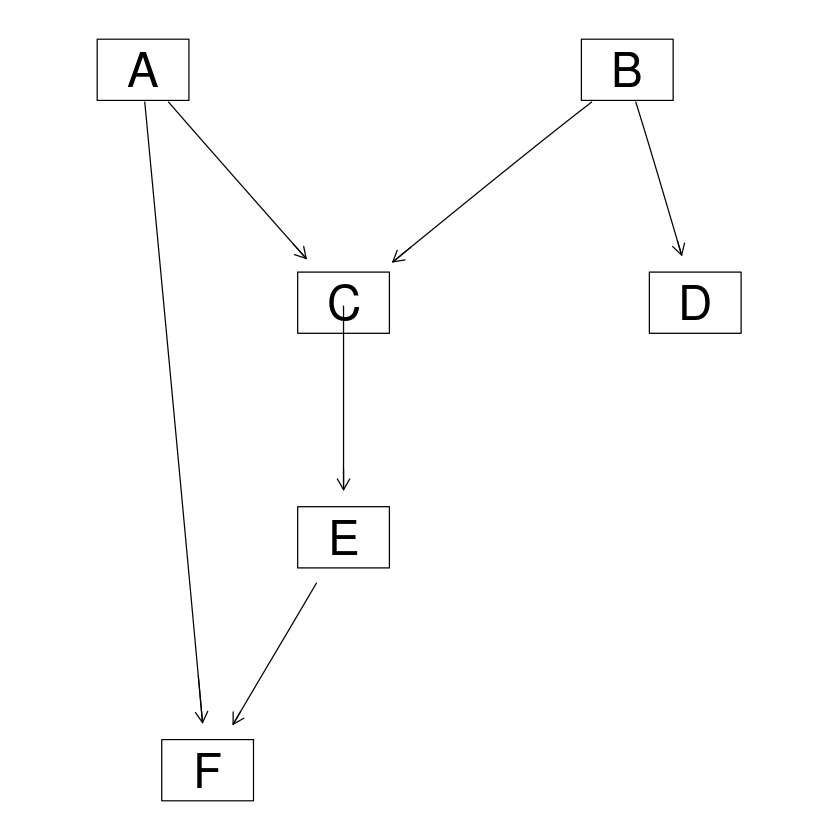

[1] 1

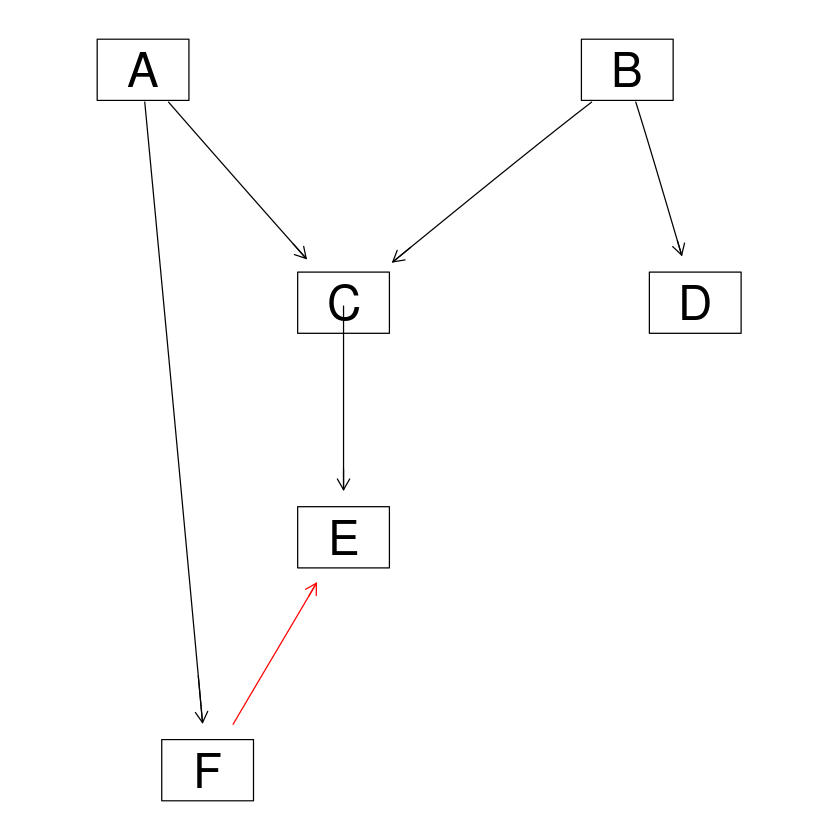

In [57]:
# Function to compute the Structural Hamming Distance (SHD) between two networks
computeShdSingle <- function(theor, empir, plot=FALSE) {
  
  # Convert the theoretical and empirical networks to adjacency matrices
  DAG1 <- amat(theor)
  DAG2 <- amat(empir)
  
  # Compute the Structural Hamming Distance between the two adjacency matrices
  shd <- shd(DAG1, DAG2)
  
  # If plot is TRUE, visualize the comparison between the two networks
  if (plot) {
    graphviz.compare(theor, empir, shape="rectangle")
  }
  
  # Return the computed SHD
  return(shd)
}

# Example usage:
# Define two Bayesian networks using model2network
e1 <- model2network("[A][B][C|A:B][D|B][E|C][F|A:E]")
e2 <- model2network("[A][B][C|A:B][D|B][E|C:F][F|A]")

# Compute the SHD between the two networks and plot the comparison
computeShdSingle(e1, e2, plot=TRUE)

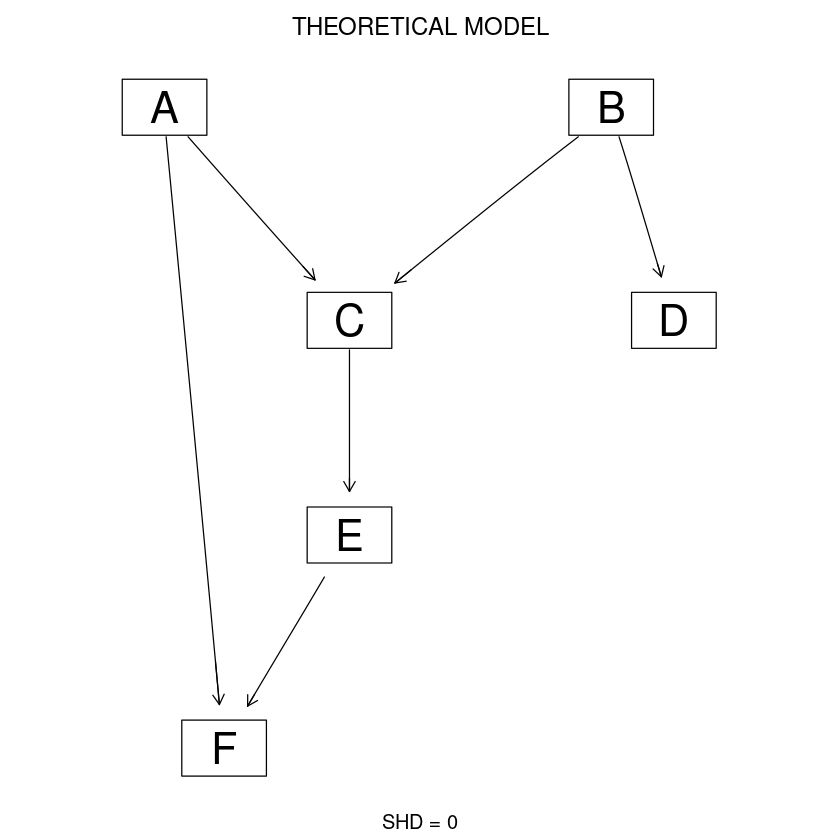

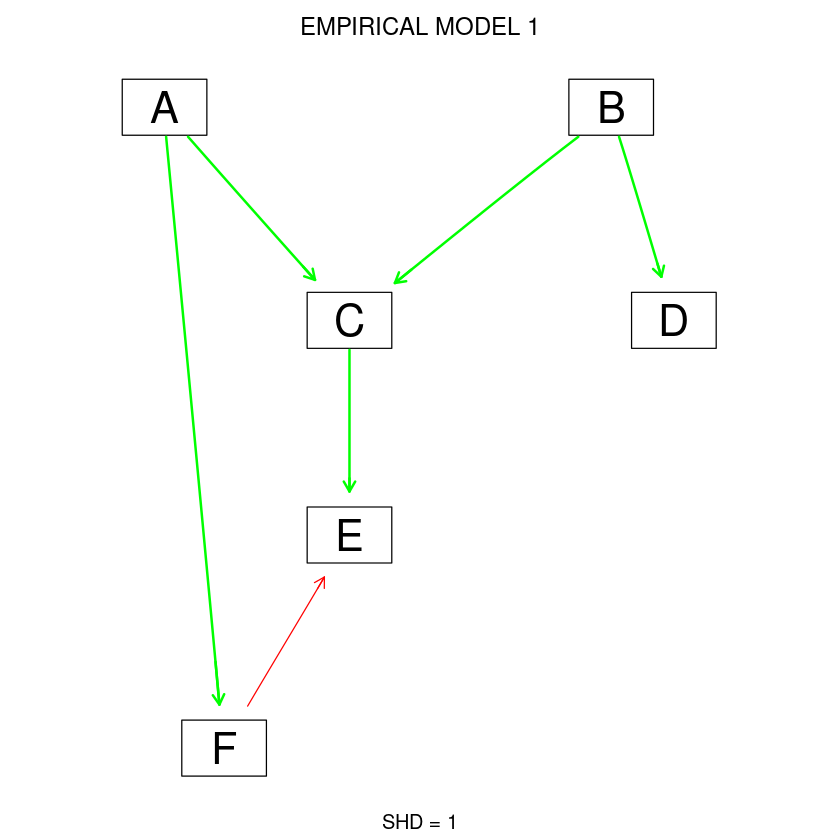

[1] 1 0


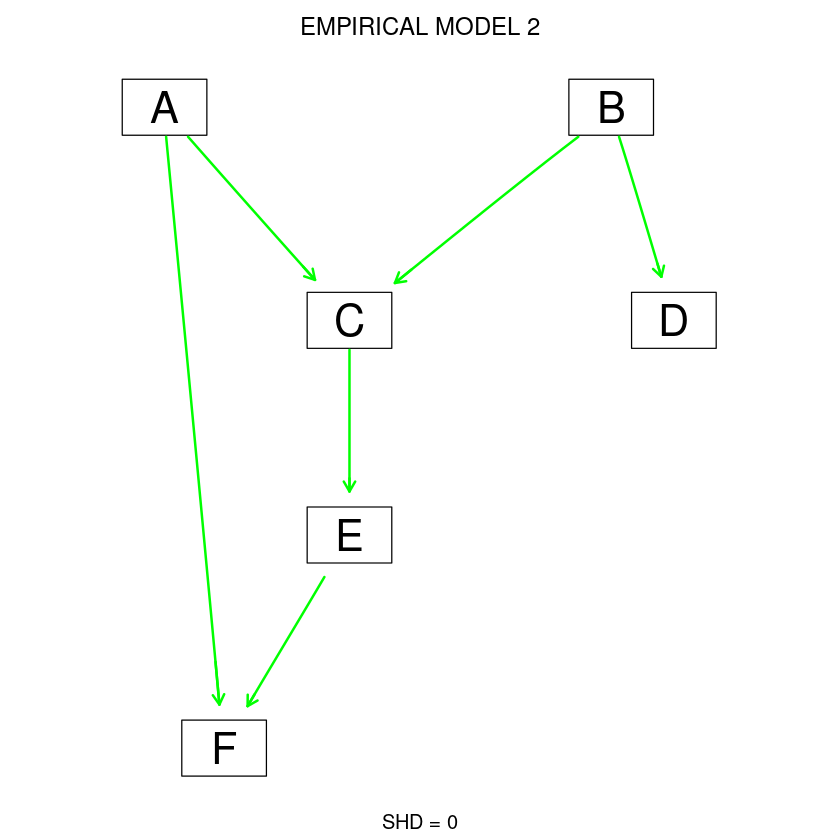

In [58]:
# Function to compute the Structural Hamming Distance (SHD) between a theoretical model and a list of empirical models
computeShd <- function(theor, empirList, plot=FALSE) {
  # Convert the theoretical model to an adjacency matrix
  DAG1 <- amat(theor)
  
  # Compute the SHD between the theoretical model and each empirical model in the list
  shd_values <- sapply(empirList, function(empir) shd(DAG1, amat(empir)))
  
  # If plot is TRUE, visualize the comparison between the models
  if (plot) {
    # Create a list of graphs to visualize, including the theoretical model and the empirical models
    plot_list <- c(list(theor), empirList)
    
    # Number of empirical models
    num_empirical <- length(empirList)
    
    # Main titles for the graphs
    titles <- c("THEORETICAL MODEL", paste("EMPIRICAL MODEL", seq_len(num_empirical)))
    # Subtitles for the graphs, including the SHD values
    subtitles <- c(paste("SHD =", "0"), paste("SHD =", shd_values))
    
    # Visualize the comparative graphs using graphviz.compare
    do.call(graphviz.compare, c(list(plot_list[[1]]), plot_list[-1], 
                                list(shape = "rectangle", 
                                     main = titles, 
                                     sub = subtitles,
                                     diff.args = list(tp.lwd = 2, tp.col = "green", fn.col = "orange"))))
  }
  
  # Return the computed SHD values
  return(shd_values)
}

# Example usage:
# Define a theoretical model using model2network
e1 <- model2network("[A][B][C|A:B][D|B][E|C][F|A:E]")

# Create a list of empirical models
empirList <- list(
  model2network("[A][B][C|A:B][D|B][E|C:F][F|A]"),
  model2network("[A][B][C|A:B][D|B][E|C][F|A:E]")
)

# Compute the SHD between the theoretical model and the empirical models, and visualize the comparison
shd_results <- computeShd(e1, empirList, plot=TRUE)
print(shd_results)

In [59]:
# Function to compute scores and DAGs for a given algorithm, data, and percentages
compute_scores_and_dags <- function(algo, data, percentages) {
  # Apply the learning function to each percentage and store the results
  results <- lapply(percentages, function(p) learning(data = data, algo = algo, maxParent = 3, percentage = p))
  
  # Extract the scores from the results
  scores <- sapply(results, function(res) res$score)
  
  # Extract the DAGs from the results
  dags <- lapply(results, function(res) res$dag)
  
  # Normalize the scores
  min_score <- min(scores)
  max_score <- max(scores)
  scores_normalized <- (scores - min_score) / (max_score - min_score)
  
  # Return a list containing the normalized scores and the DAGs
  return(list(scores = scores_normalized, dags = dags))
}

# RUIZ DATA SET

In [60]:
records <- c(1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0)
ruiz_example  <- data.frame(matrix(records, 10,3, byrow=TRUE))

ruiz_example

X1,X2,X3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


bnstruct :: structure learning algorithm not recognized, using MMHC

bnstruct :: (available options are: SM, MMHC, MMPC, HC, SEM)

bnstruct :: MMHC uses 'max.fanin', but apparently you set 'max.parents', changing accordingly.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



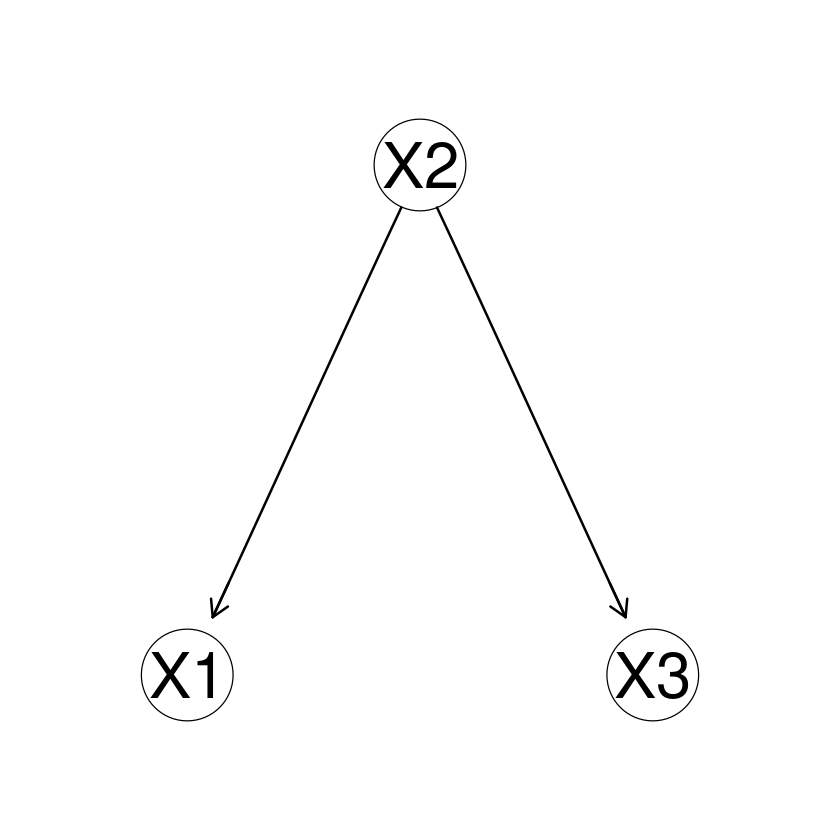

In [61]:
dagRuiz <- learning(data = ruiz_example,  maxParent=5, algo = "k2", percentage = 1, plot = T)

In [62]:
dagRuiz$dag
dagRuiz$score


  Random/Generated Bayesian network

  model:
   [X2][X1|X2][X3|X2] 
  nodes:                                 3 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.33 
  average branching factor:              0.67 

  generation algorithm:                  Empty 


[1] -20.19397

# ASIA DATA SET

In [63]:
asia_df <- asia() |> # S4 object
  impute() |> # Impute the dataset to remove missing values
  imputed.data() |> # Extract the imputed dataset
  as.data.frame() # Convert to a data frame

# Set the column names
colnames(asia_df) <- asia()@variables
print(colnames(asia_df))

head(asia_df)

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



[1] "Asia"         "Tubercolosys" "Smoke"        "LungCancer"   "Bronchitis"  
[6] "Either"       "X-ray"        "Dyspnea"     


,Asia,Tubercolosys,Smoke,LungCancer,Bronchitis,Either,X-ray,Dyspnea
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,2,1,1,1,2,1,2
2,2,1,1,1,1,1,2,1
3,1,1,2,1,1,1,2,1
4,2,1,2,1,1,1,2,1
5,2,1,2,1,1,1,1,2
6,2,1,2,1,1,1,2,2


In [64]:
# Define a vector of algorithms to be used for learning the DAGs
algorithms <- c("hc", "sm", "mmpc", "mmhc", "sem")

# Initialize empty lists to store the DAGs and their scores
dag_listAsia <- list()
score_listAsia <- list()

# Loop through each algorithm in the algorithms vector
for (algo in algorithms) {
  # Learn the DAG using the specified algorithm and parameters
  dagAsia <- learning(asia_df, maxParent=5, algo = algo, percentage = 1, plot = F)
  
  # Store the learned DAG in the dag_listAsia list, using the algorithm name as the key
  dag_listAsia[[algo]] <- dagAsia$dag
  
  # Store the score of the learned DAG in the score_listAsia list, using the algorithm name as the key
  score_listAsia[[algo]] <- dagAsia$score
}

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: MMPC uses 'max.fanin', but apparently you set 'max.parents', changing accordingly.

bnstruct :: learning the structure using MMPC ...

bnstruct :: learning using MMPC completed.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: learning the structure using SEM ...

... bnstruct :: no missing values found, learning the network once

... bnstruct 

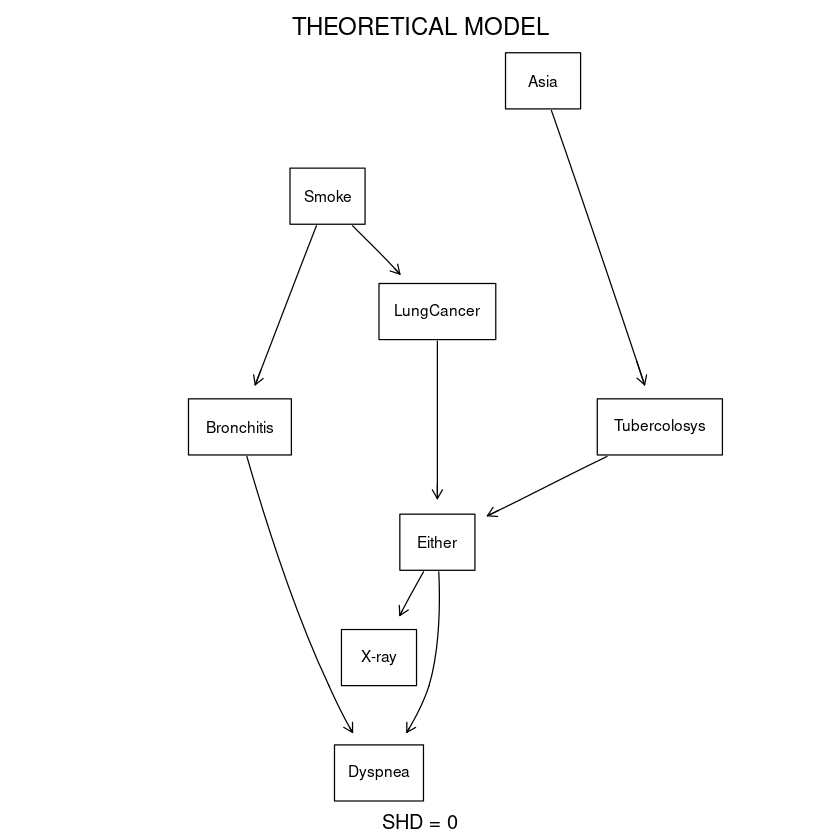

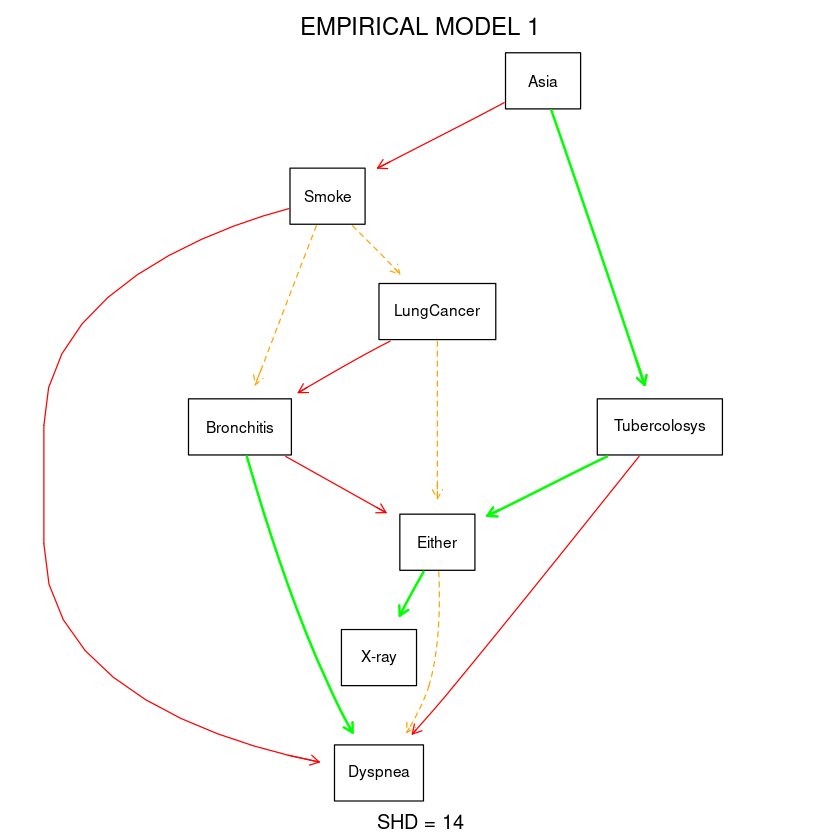

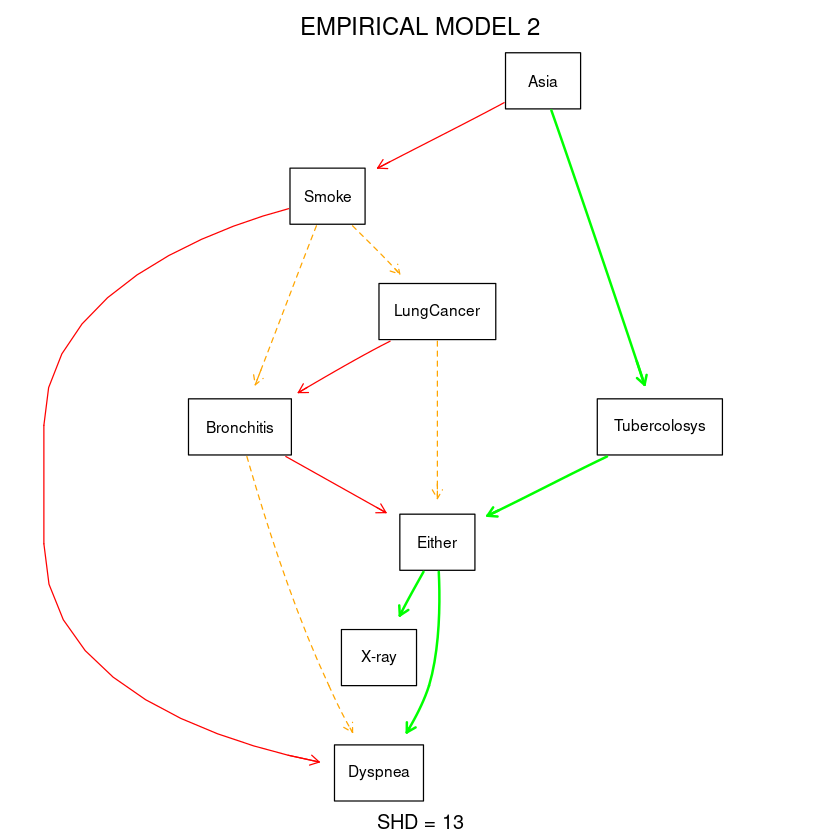

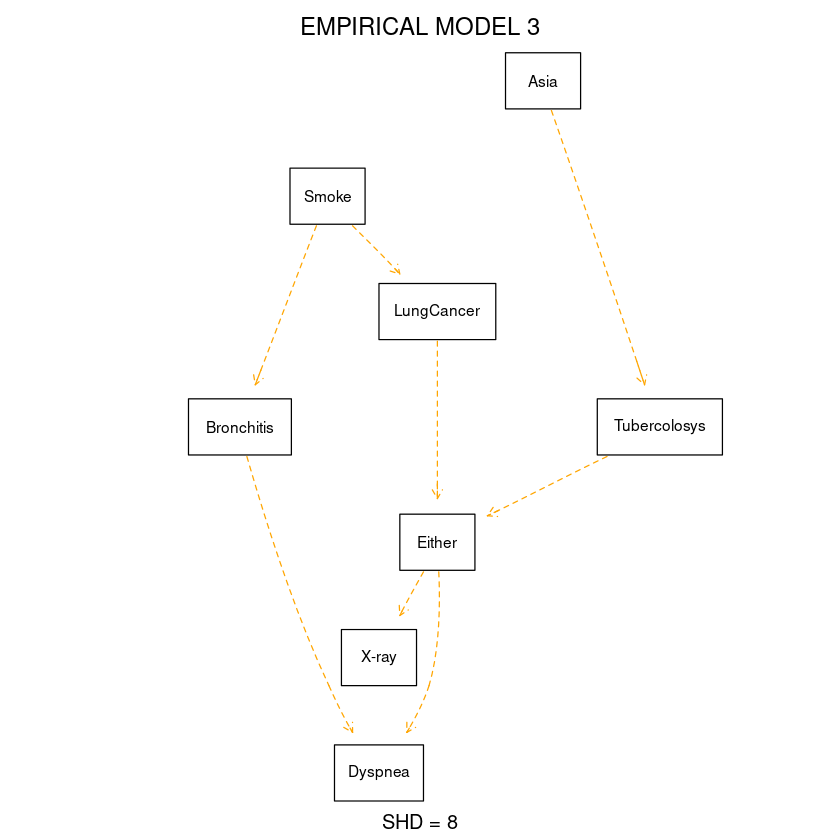

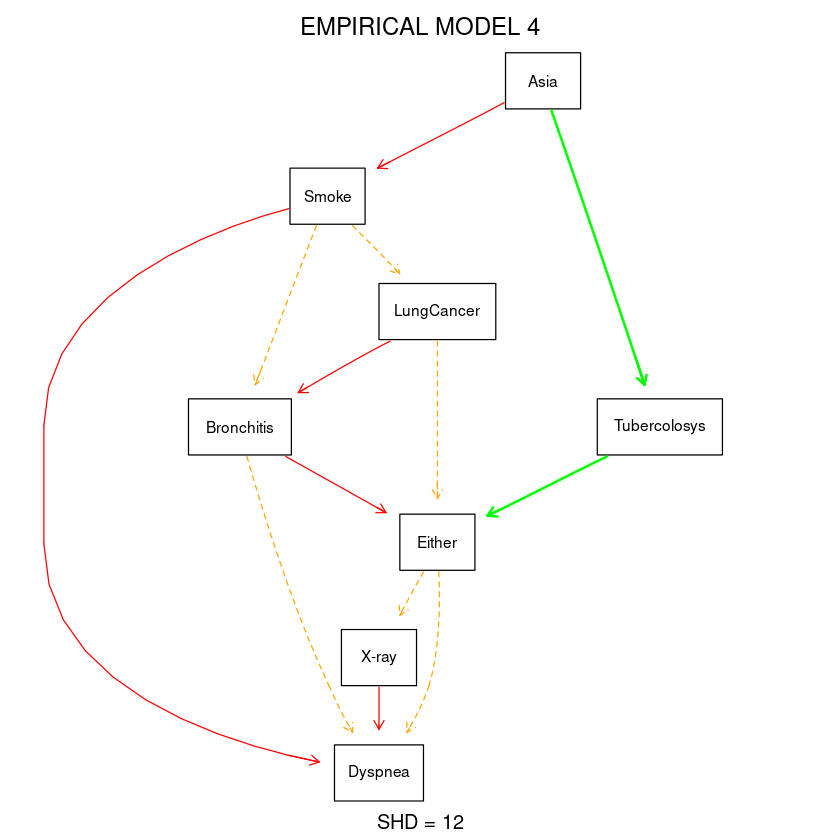

hc   sm mmpc mmhc  sem 
  14   13    8   12   12

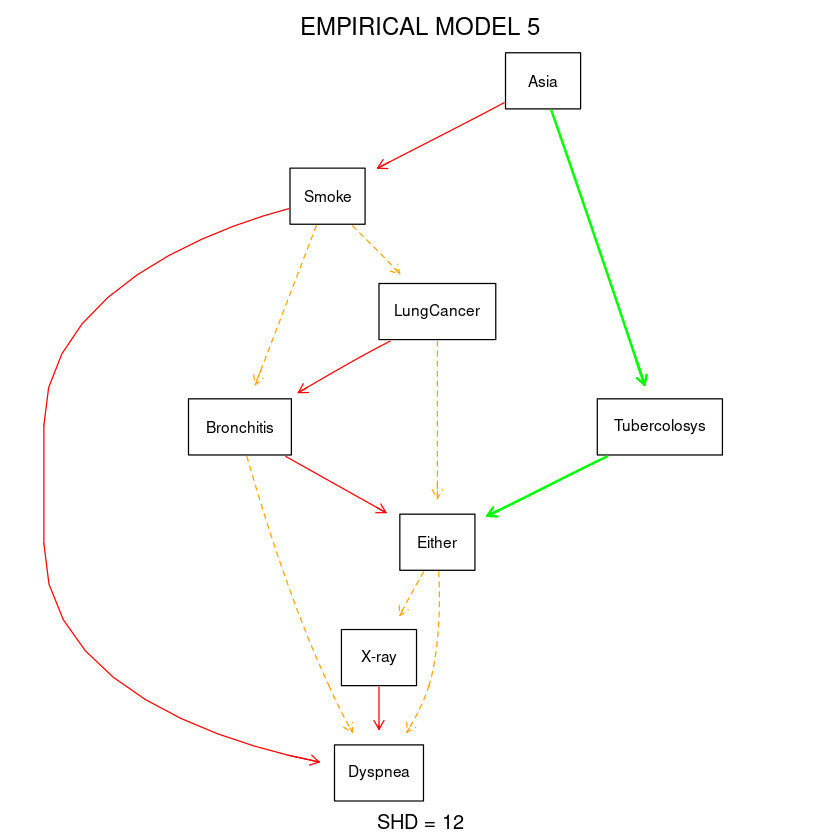

In [65]:
# Define the theoretical DAG using the model2network function
theorDAG <- model2network("[Asia][Tubercolosys|Asia][Smoke][LungCancer|Smoke][Either|Tubercolosys:LungCancer][X-ray|Either][Dyspnea|Either:Bronchitis][Bronchitis|Smoke]")

# Assign the list of learned DAGs to a variable
listAsia <- dag_listAsia

# Compute the Structural Hamming Distance (SHD) between the theoretical DAG and the list of learned DAGs
# Also, plot the comparison between the theoretical DAG and each learned DAG
computeShd(theorDAG, dag_listAsia, plot = T)
theorDAG_asia <- theorDAG

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fan

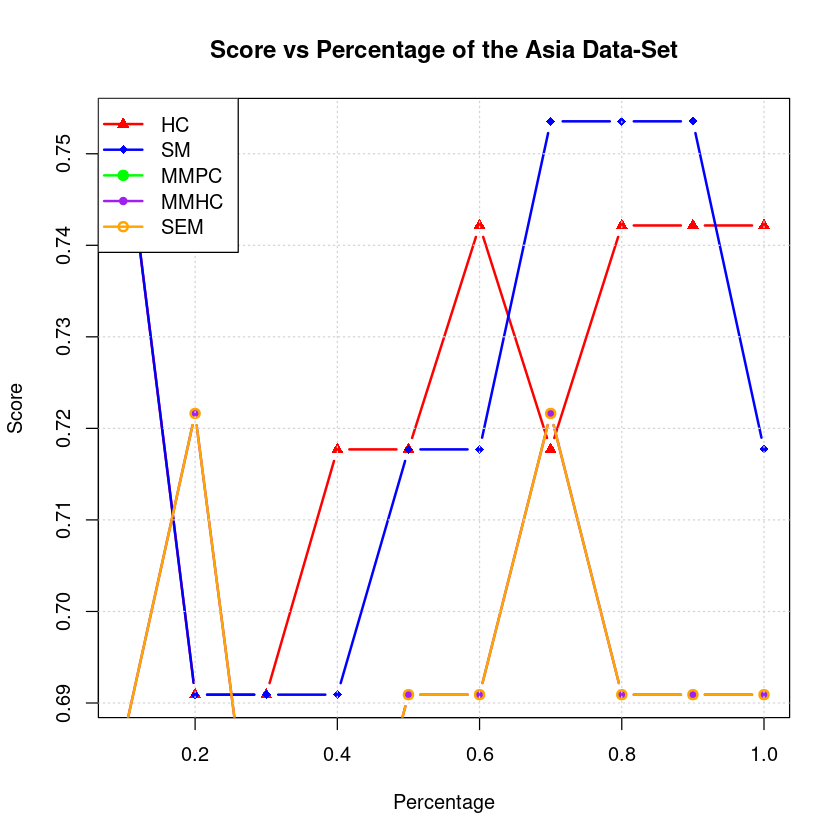

In [66]:
percentages <- seq(0.1, 1, by = 0.1)


# Define a vector of algorithms to be used
algorithms <- c("hc", "sm", "mmpc", "mmhc", "sem")

# Apply the compute_scores_and_dags function to each algorithm and store the results
results <- lapply(algorithms, function(algo) compute_scores_and_dags2(algo, theorDAG, asia_df, percentages))

# Extract the scores and DAGs from the results
scores_list <- lapply(results, function(res) res$scores)
dags_list <- lapply(results, function(res) res$dags)

# Assign the algorithm names to the scores and DAGs lists
names(scores_list) <- algorithms
names(dags_list) <- algorithms

# Define colors and plotting characters for the plot
colors <- c("red", "blue", "green", "purple", "orange")
pch_values <- 17:21

# Plot the scores for the first algorithm
plot(percentages, scores_list[[1]], type = "b", pch = pch_values[1], col = colors[1], lwd = 2,
     main = "Score vs Percentage of the Asia Data-Set", xlab = "Percentage", ylab = "Score")

# Add lines for the scores of the remaining algorithms
for (i in 2:length(algorithms)) {
  lines(percentages, scores_list[[i]], type = "b", pch = pch_values[i], col = colors[i], lwd = 2)
}

# Add a grid to the plot
grid(col = "lightgray", lty = "dotted")

# Add a legend to the plot
legend("topleft", legend = toupper(algorithms),
       col = colors, pch = pch_values, lty = 1, lwd = 2)

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fan

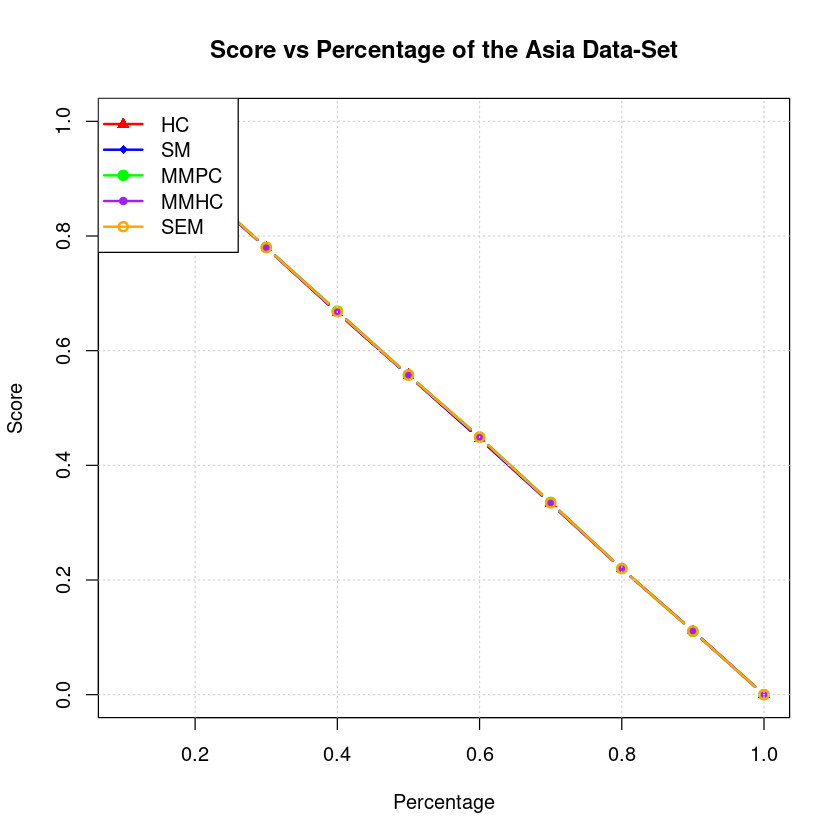

In [67]:
# Define a sequence of percentages from 0.1 to 1, incrementing by 0.1
percentages <- seq(0.1, 1, by = 0.1)


# Define a vector of algorithms to be used
algorithms <- c("hc", "sm", "mmpc", "mmhc", "sem")

# Apply the compute_scores_and_dags function to each algorithm and store the results
results <- lapply(algorithms, function(algo) compute_scores_and_dags(algo, asia_df, percentages))

# Extract the scores and DAGs from the results
scores_list <- lapply(results, function(res) res$scores)
dags_list <- lapply(results, function(res) res$dags)

# Assign the algorithm names to the scores and DAGs lists
names(scores_list) <- algorithms
names(dags_list) <- algorithms

# Define colors and plotting characters for the plot
colors <- c("red", "blue", "green", "purple", "orange")
pch_values <- 17:21

# Plot the scores for the first algorithm
plot(percentages, scores_list[[1]], type = "b", pch = pch_values[1], col = colors[1], lwd = 2,
     main = "Score vs Percentage of the Asia Data-Set", xlab = "Percentage", ylab = "Score")

# Add lines for the scores of the remaining algorithms
for (i in 2:length(algorithms)) {
  lines(percentages, scores_list[[i]], type = "b", pch = pch_values[i], col = colors[i], lwd = 2)
}

# Add a grid to the plot
grid(col = "lightgray", lty = "dotted")

# Add a legend to the plot
legend("topleft", legend = toupper(algorithms),
       col = colors, pch = pch_values, lty = 1, lwd = 2)

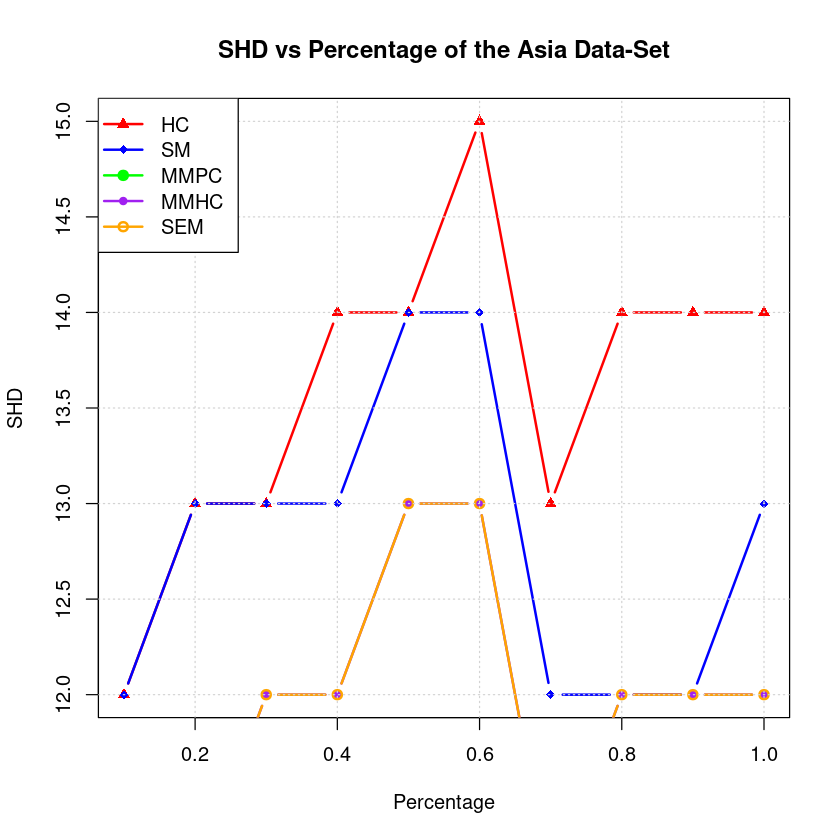

In [68]:
# Define a sequence of percentages from 0.1 to 1, incrementing by 0.1
percentages <- seq(0.1, 1, by = 0.1)

# Initialize an empty list to store the SHD values
shd_values <- list()

# Loop through each list of DAGs in dags_list
for (i in 1:length(dags_list)) {
  # Compute the SHD between the theoretical DAG and each empirical DAG in the current list
  shd_values[[i]] <- sapply(dags_list[[i]], function(dag) computeShdSingle(theor = theorDAG, empir = dag)[1])
}

# Define colors and plotting characters for the plot
colors <- c("red", "blue", "green", "purple", "orange")
pch_values <- 17:21

# Plot the SHD values for the first algorithm
plot(percentages, shd_values[[1]], type = "b", pch = pch_values[1], col = colors[1], lwd = 2,
     main = "SHD vs Percentage of the Asia Data-Set", xlab = "Percentage", ylab = "SHD")

# Add lines for the SHD values of the remaining algorithms
for (i in 2:length(shd_values)) {
  lines(percentages, shd_values[[i]], type = "b", pch = pch_values[i], col = colors[i], lwd = 2)
}

# Add a grid to the plot
grid(col = "lightgray", lty = "dotted")

# Add a legend to the plot
legend("topleft", legend = toupper(algorithms),
       col = colors, pch = pch_values, lty = 1, lwd = 2)

# CHILD DATA SET

In [69]:
# Load the data
child_df <- child() |> # S4 object
  impute() |> # Impute the dataset to remove missing values
  imputed.data() |> # Extract the imputed dataset
  as.data.frame() # Convert to a data frame

# Set the column names
colnames(child_df) <- child()@variables
print(colnames(child_df))

head(child_df)

bnstruct :: performing imputation ...



bnstruct :: imputation finished.



 [1] "BirthAsphyxia"  "Disease"        "Age"            "LVH"           
 [5] "DuctFlow"       "CardiacMixing"  "LungParench"    "LungFlow"      
 [9] "Sick"           "HypDistrib"     "HypoxiaInO2"    "CO2"           
[13] "ChestXray"      "Grunting"       "LVHReport"      "LowerBodyO2"   
[17] "RUQO2"          "CO2Report"      "XrayReport"     "GruntingReport"


,BirthAsphyxia,Disease,Age,LVH,DuctFlow,CardiacMixing,LungParench,LungFlow,Sick,HypDistrib,HypoxiaInO2,CO2,ChestXray,Grunting,LVHReport,LowerBodyO2,RUQO2,CO2Report,XrayReport,GruntingReport
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,3,3,2,1,3,1,1,2,1,1,1,1,2,2,2,3,2,1,2
2,2,4,2,1,1,2,1,2,2,1,2,1,2,2,1,2,2,1,2,2
3,2,3,1,2,1,3,1,2,2,1,2,2,2,2,2,1,2,1,2,2
4,2,4,1,1,1,3,1,1,2,1,3,1,1,2,1,3,1,1,1,2
5,2,2,1,2,2,4,1,1,1,1,3,1,1,2,2,1,1,1,2,2
6,2,2,1,2,1,4,1,3,2,1,3,1,3,2,2,2,1,1,3,2


In [70]:
# Define a vector of algorithms to be used for learning the DAGs
algorithms <- c("hc", "sm", "mmpc", "mmhc", "sem")

# Initialize empty lists to store the DAGs and their scores
dag_listChild <- list()
score_listChild <- list()

# Loop through each algorithm in the algorithms vector
for (algo in algorithms) {
  # Learn the DAG using the specified algorithm and parameters
  dagChild <- learning(child_df, maxParent=5, algo = algo, percentage = 1, plot = F)
  
  # Store the learned DAG in the dag_listAsia list, using the algorithm name as the key
  dag_listChild[[algo]] <- dagChild$dag
  
  # Store the score of the learned DAG in the score_listAsia list, using the algorithm name as the key
  score_listChild[[algo]] <- dagChild$score
}

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: MMPC uses 'max.fanin', but apparently you set 'max.parents', changing accordingly.

bnstruct :: learning the structure using MMPC ...

bnstruct :: learning using MMPC completed.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: learning the structure using SEM ...

... bnstruct :: no missing values found, learning the network once

... bnstruct 

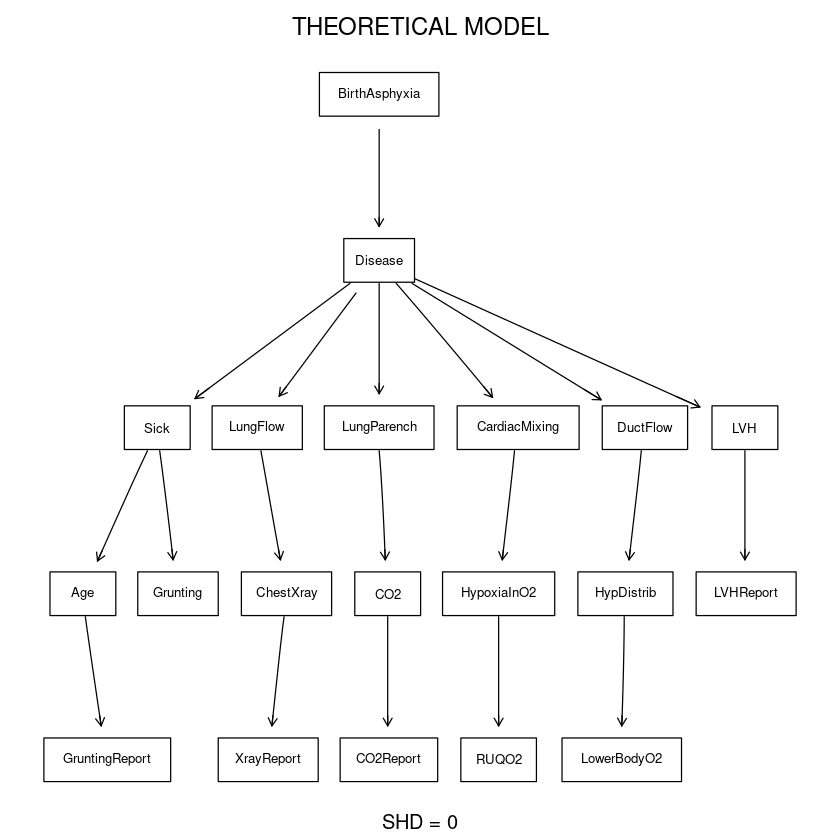

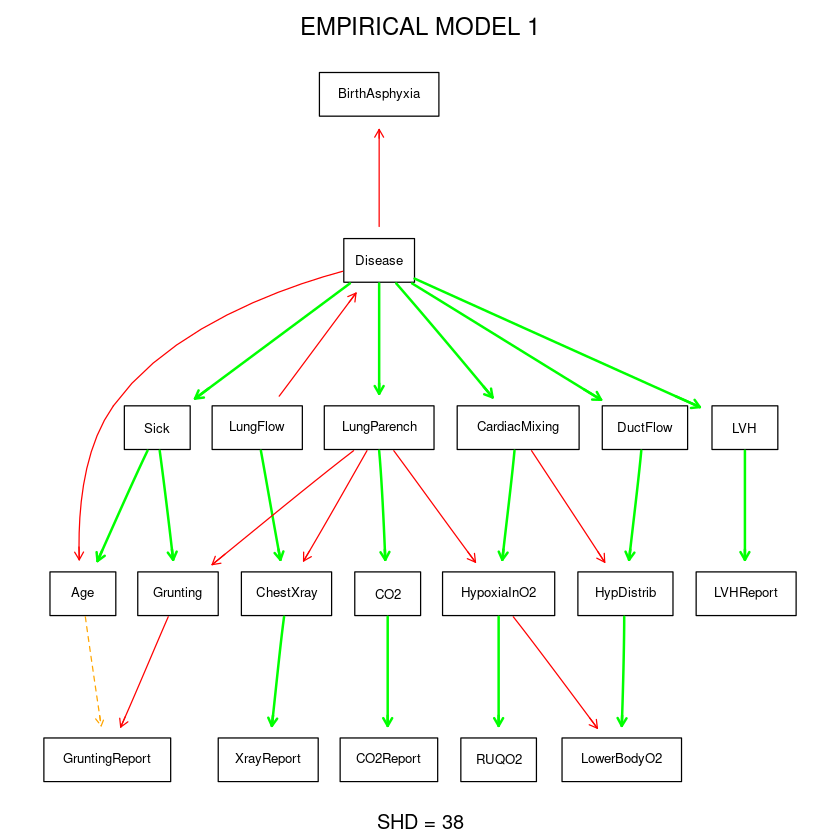

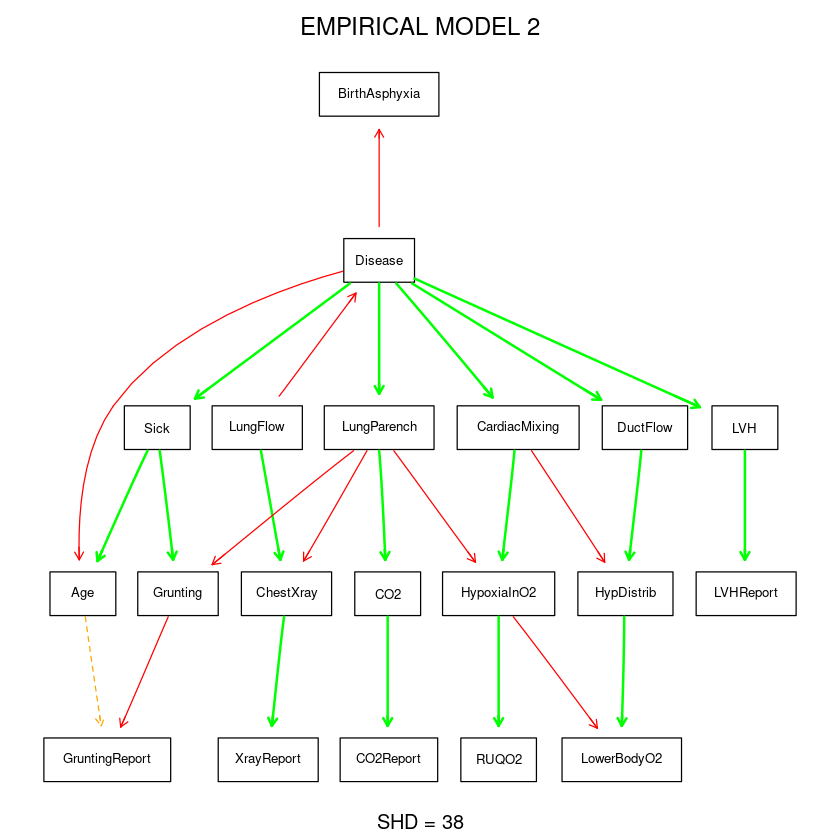

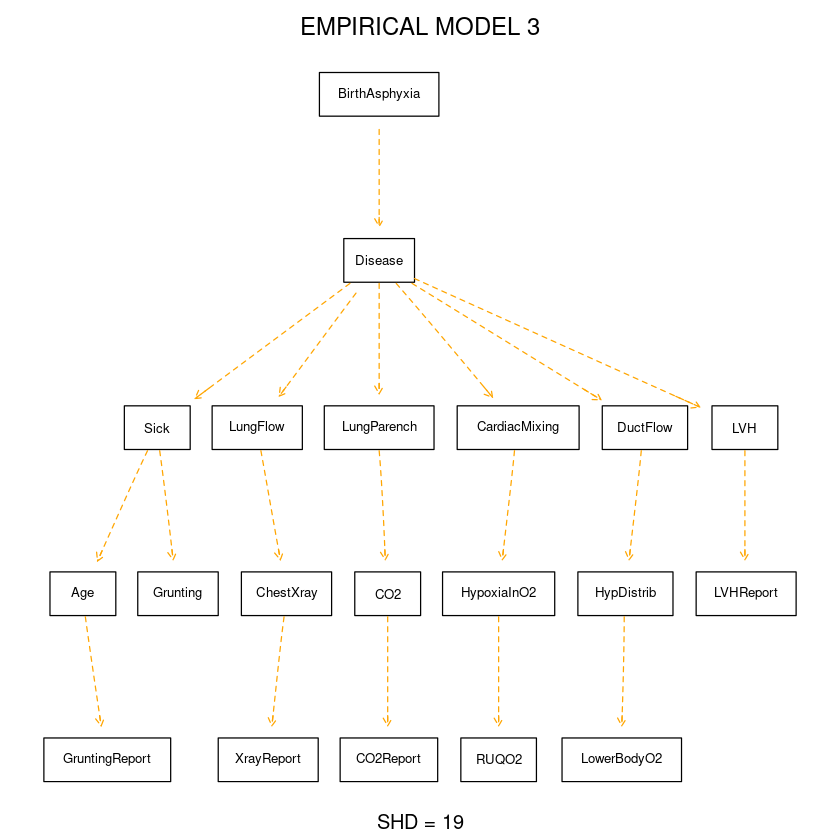

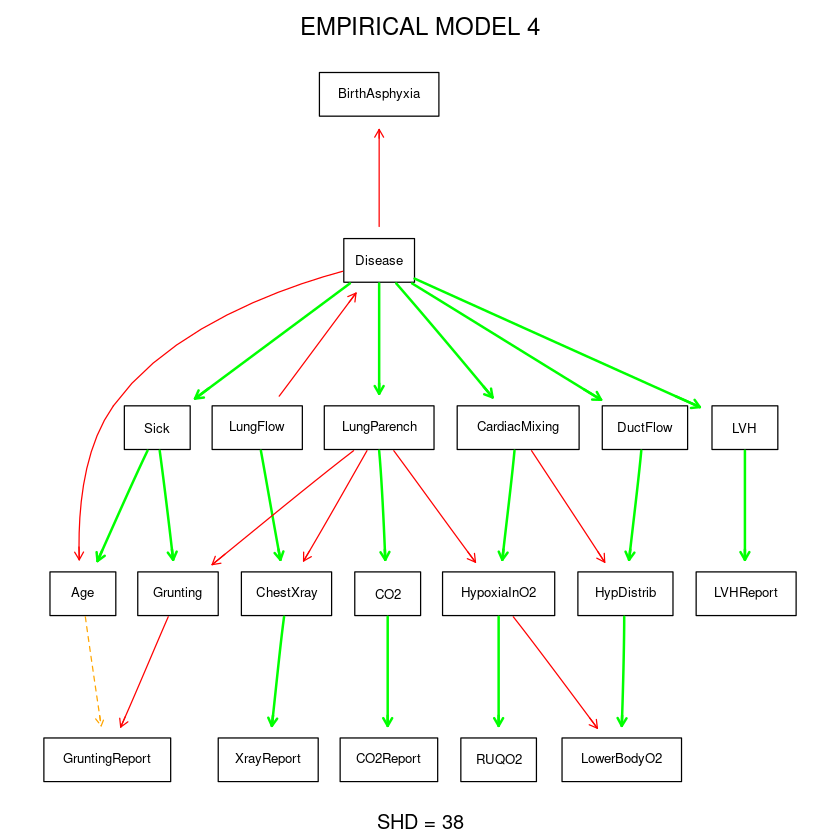

hc   sm mmpc mmhc  sem 
  38   38   19   38   38

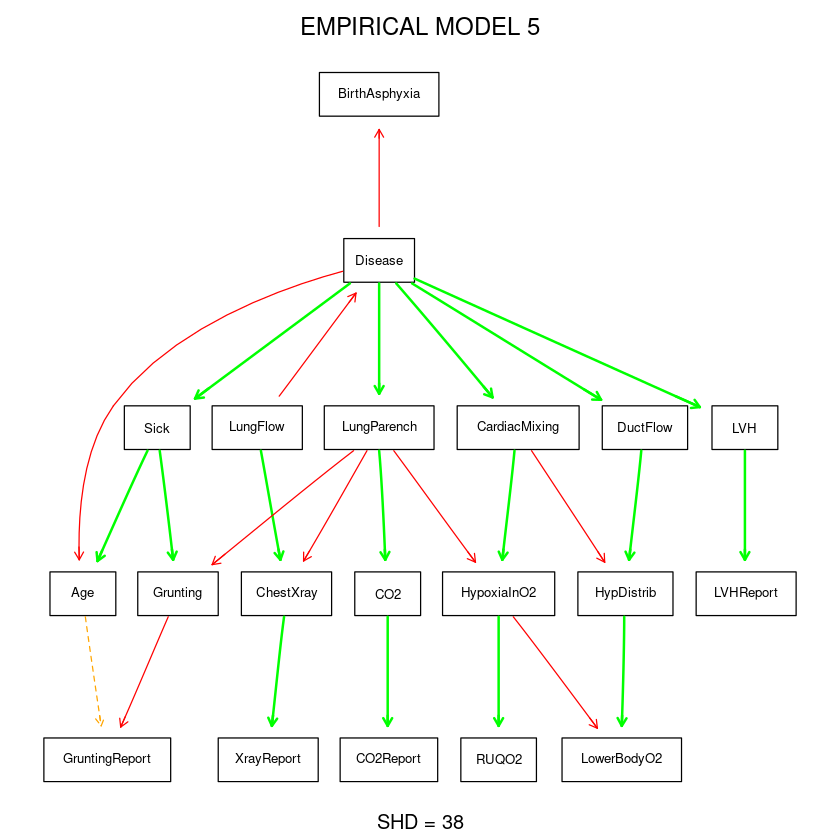

In [84]:
# Define the theoretical DAG using the model2network function
theorDAG <- model2network("[BirthAsphyxia][Disease|BirthAsphyxia][Sick|Disease][DuctFlow|Disease][CardiacMixing|Disease][LungParench|Disease][LungFlow|Disease][LVH|Disease][Age|Sick][Grunting|Sick][HypDistrib|DuctFlow][HypoxiaInO2|CardiacMixing][CO2|LungParench][ChestXray|LungFlow][LVHReport|LVH][GruntingReport|Age][LowerBodyO2|HypDistrib][RUQO2|HypoxiaInO2][CO2Report|CO2][XrayReport|ChestXray]")

# Assign the list of learned DAGs to a variable
listChild <- dag_listChild

# Compute the Structural Hamming Distance (SHD) between the theoretical DAG and the list of learned DAGs
# Also, plot the comparison between the theoretical DAG and each learned DAG
computeShd(theorDAG, dag_listChild, plot = T)
theorDAG_child <- theorDAG

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fanin' and 'layer.struct' parameters, but apparently you set 'max.parents' and 'max.parents.layers', changing accordingly.

bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.

bnstruct :: HC uses 'max.fan

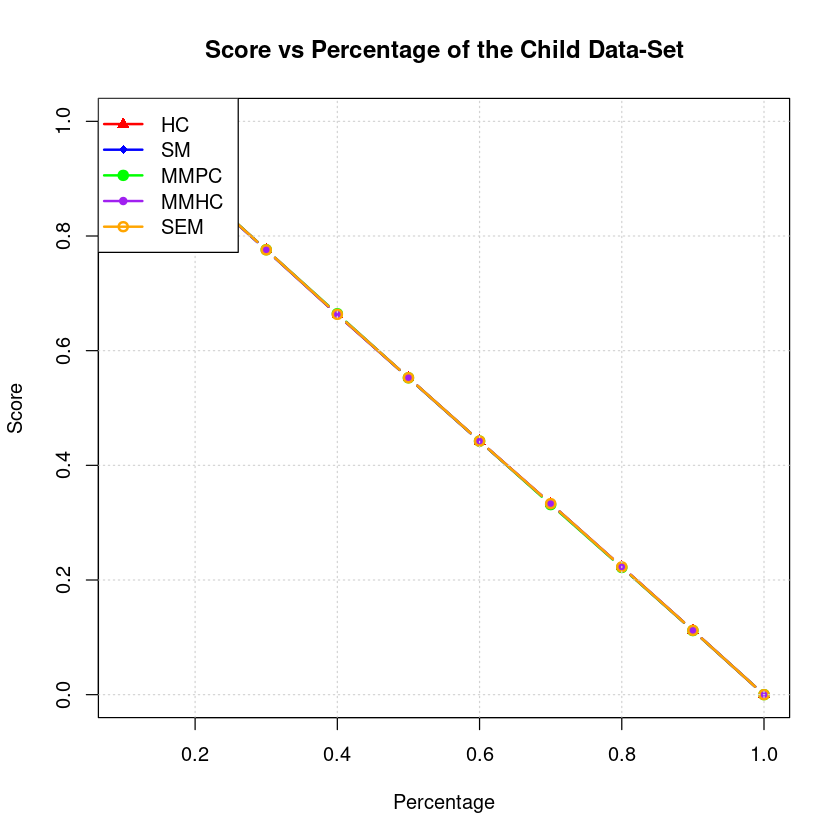

In [73]:
# Define a sequence of percentages from 0.1 to 1, incrementing by 0.1
percentages <- seq(0.1, 1, by = 0.1)

# Define a vector of algorithms to be used
algorithms <- c("hc", "sm", "mmpc", "mmhc", "sem")

# Apply the compute_scores_and_dags function to each algorithm and store the results
results <- lapply(algorithms, function(algo) compute_scores_and_dags(algo, child_df, percentages))

# Extract the scores and DAGs from the results
scores_list <- lapply(results, function(res) res$scores)
dags_list <- lapply(results, function(res) res$dags)

# Assign the algorithm names to the scores and DAGs lists
names(scores_list) <- algorithms
names(dags_list) <- algorithms

# Define colors and plotting characters for the plot
colors <- c("red", "blue", "green", "purple", "orange")
pch_values <- 17:21

# Plot the scores for the first algorithm
plot(percentages, scores_list[[1]], type = "b", pch = pch_values[1], col = colors[1], lwd = 2,
     main = "Score vs Percentage of the Child Data-Set", xlab = "Percentage", ylab = "Score")

# Add lines for the scores of the remaining algorithms
for (i in 2:length(algorithms)) {
  lines(percentages, scores_list[[i]], type = "b", pch = pch_values[i], col = colors[i], lwd = 2)
}

# Add a grid to the plot
grid(col = "lightgray", lty = "dotted")

# Add a legend to the plot
legend("topleft", legend = toupper(algorithms),
       col = colors, pch = pch_values, lty = 1, lwd = 2)

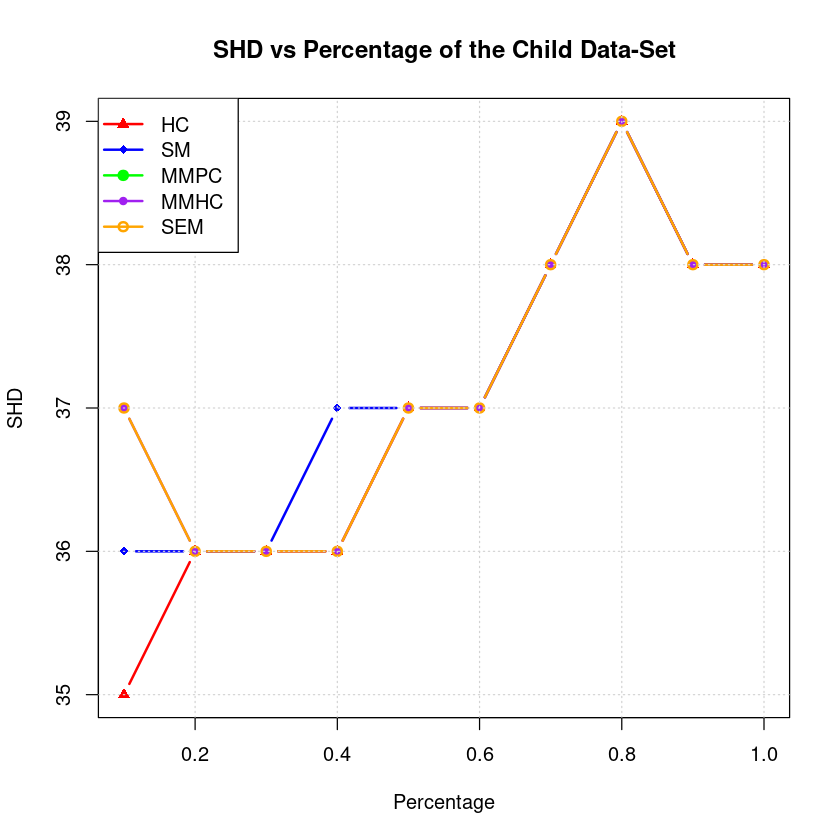

In [74]:
# Define a sequence of percentages from 0.1 to 1, incrementing by 0.1
percentages <- seq(0.1, 1, by = 0.1)

# Initialize an empty list to store the SHD values
shd_values <- list()

# Loop through each list of DAGs in dags_list
for (i in 1:length(dags_list)) {
  # Compute the SHD between the theoretical DAG and each empirical DAG in the current list
  shd_values[[i]] <- sapply(dags_list[[i]], function(dag) computeShdSingle(theor = theorDAG, empir = dag)[1])
}

# Define colors and plotting characters for the plot
colors <- c("red", "blue", "green", "purple", "orange")
pch_values <- 17:21

# Plot the SHD values for the first algorithm
plot(percentages, shd_values[[1]], type = "b", pch = pch_values[1], col = colors[1], lwd = 2,
     main = "SHD vs Percentage of the Child Data-Set", xlab = "Percentage", ylab = "SHD")

# Add lines for the SHD values of the remaining algorithms
for (i in 2:length(shd_values)) {
  lines(percentages, shd_values[[i]], type = "b", pch = pch_values[i], col = colors[i], lwd = 2)
}

# Add a grid to the plot
grid(col = "lightgray", lty = "dotted")

# Add a legend to the plot
legend("topleft", legend = toupper(algorithms),
       col = colors, pch = pch_values, lty = 1, lwd = 2)

## Confronti

In [86]:
## Scoring function for exact results
scoring_function <- function(data, x_i, parents){
  # Find the possible values of the attribute i
  r_i <- data |> distinct(data[[x_i]]) |> nrow()

  if (length(parents) == 0){
    N <- nrow(data)

    num1 <- data |> 
      group_by(data[[x_i]]) |> 
      count() |> 
      mutate(a = factorial(n)) |> 
      ungroup() |> 
      pull(a) |>
      prod()

    # To do consistently with the other case
  } else {
    alpha <- data |> group_by(data[c(x_i, parents)]) |> count()

    N <- alpha |> group_by(alpha[parents]) |> 
      summarise(N = sum(n), .groups = "drop") |> 
      select(N)

    num1 <- alpha |>
      group_by(alpha[parents]) |>
      summarise(alpha = prod(factorial(n)), .groups = "drop") |>
      pull(alpha)
  }

  # Calculate the score
  den <- sapply(N, function(x, r) factorial(x + r - 1), r=r_i)
  num2 <- factorial(r_i - 1)

  return(prod(num2 / den * num1))
}

## Log scoring function to avoid numerical issues
log_scoring_function <- function(data, x_i, parents) {
    # Find the possible values of the attribute i
    r_i <- data |>
        distinct(data[[x_i]]) |>
        nrow()

    if (length(parents) == 0) {
        N <- nrow(data)

        num1 <- data |>
            group_by(data[[x_i]]) |>
            count() |>
            mutate(a = lfactorial(n)) |>
            ungroup() |>
            pull(a) |>
            sum()

        # To do consistently with the other case
    } else {
        alpha <- data |>
            group_by(data[c(x_i, parents)]) |>
            count()

        N <- alpha |>
            group_by(alpha[parents]) |>
            summarise(N = sum(n), .groups = "drop") |>
            select(N)

        num1 <- alpha |>
            group_by(alpha[parents]) |>
            summarise(alpha = sum(lfactorial(n)), .groups = "drop") |>
            pull(alpha)
    }

    # Calculate the score
    den <- sapply(N, function(x, r) lfactorial(x + r - 1), r = r_i)
    num2 <- lfactorial(r_i - 1)

    return(sum(num1 - den + num2))
}
K2_algorithm <- function(data, max_parents) {
    names <- colnames(data)
    results <- c()

    for (i in 1:ncol(data)) {
        x_i <- names[i]
        parents <- c()
        p_old <- log_scoring_function(data, x_i, parents)
        proceed <- TRUE

        while (proceed) {
            # Check if the maximum number of parents has been reached
            if (length(parents) >= max_parents) {
                break
            }

            # Compute the predecessors
            predecessors <- setdiff(names[0:(i - 1)], parents)
            if (length(predecessors) == 0) {
                break
            }

            # Try adding a new parent
            scores <- sapply(predecessors, function(z) log_scoring_function(data, x_i, c(z, parents)))
            p_new <- max(scores)

            # If the score increases, add the parent
            if (p_new > p_old) {
                p_old <- p_new
                parents <- c(parents, names[which.max(scores)])
            } else {
                proceed <- FALSE
            }
        } # end while

        results[[x_i]] <- parents
    } # end for

    return(list(names = names, parents_list = results))
}
get_dag <- function(names, parents_list) {
  dag <- empty.graph(names)

  # Add arcs based on the parent-child relationships
  for (child in names) {
    parents <- parents_list[[child]]
    if (length(parents) > 0) {
      for (parent in parents) {
        dag <- set.arc(dag, from = parent, to = child)
      }
    }
  }
  return(dag)
}
K2_to_dag <- function(data, max_parents) {
  # Run the K2 algorithm
  results <- K2_algorithm(data, max_parents)
  names <- results$names
  parents_list <- results$parents_list

  # Convert the parent-child relationships to a DAG
  dag <- get_dag(names, parents_list)

  # Get the score of the DAG
  score <- score(dag, data)

  return(list(dag = dag, score = score))
}
K2_pipeline <- function(data, max_parents, max_iter, mode = "local", n_cores = -1) {
  # Check if the mode is valid
  if (mode != "local" && mode != "parallel") {
    stop("Invalid mode. Please use 'local' or 'parallel'.")
  }

  # If the data does not have column names, assign them
  if (is.null(colnames(data))) {
    colnames(data) <- paste0("X", 1:ncol(data))
  }

  # Try different random orders of the columns
  if (mode == "local") {
    # Initialize the best score and DAG
    score_best <- -Inf
    dag_best <- NULL

    # Try different random orders of the columns
    for (i in 1:max_iter) {
      data <- data |> select(sample(colnames(data)))
      result <- K2_to_dag(data, max_parents)
      score <- result$score

      # Update the best DAG
      if (score > score_best) {
        score_best <- score
        dag_best <- result$dag
      }
    }

    return(list(dag = dag_best, score = score_best))
  } else if (mode == "parallel") {
    # Setup parallel processing
    if (n_cores == -1) {
      n_cores <- detectCores()
    }
    cl <- makeCluster(n_cores)
    registerDoParallel(cl)

    # Try different random orders of the columns in parallel
    results <- mclapply(1:max_iter, function(i) {
      data_sampled <- data |> select(sample(colnames(data)))
      result <- K2_to_dag(data_sampled, max_parents)
      return(result)
    }, mc.cores = n_cores)

    # Initialize best score and DAG
    score_best <- -Inf
    dag_best <- NULL

    # Find the best result
    for (res in results) {
      if (res$score > score_best) {
        score_best <- res$score
        dag_best <- res$dag
      }
    }

    return(list(dag = dag_best, score = score_best))
  }

  return(NULL)
}
res_asia <- K2_pipeline(asia_df, max_parents = 3, max_iter = 3)
dag.asia.k2 <- res_asia$dag

res_child <- K2_pipeline(child_df, max_parents = 3, max_iter = 3)
dag.child.k2 <- res_child$dag

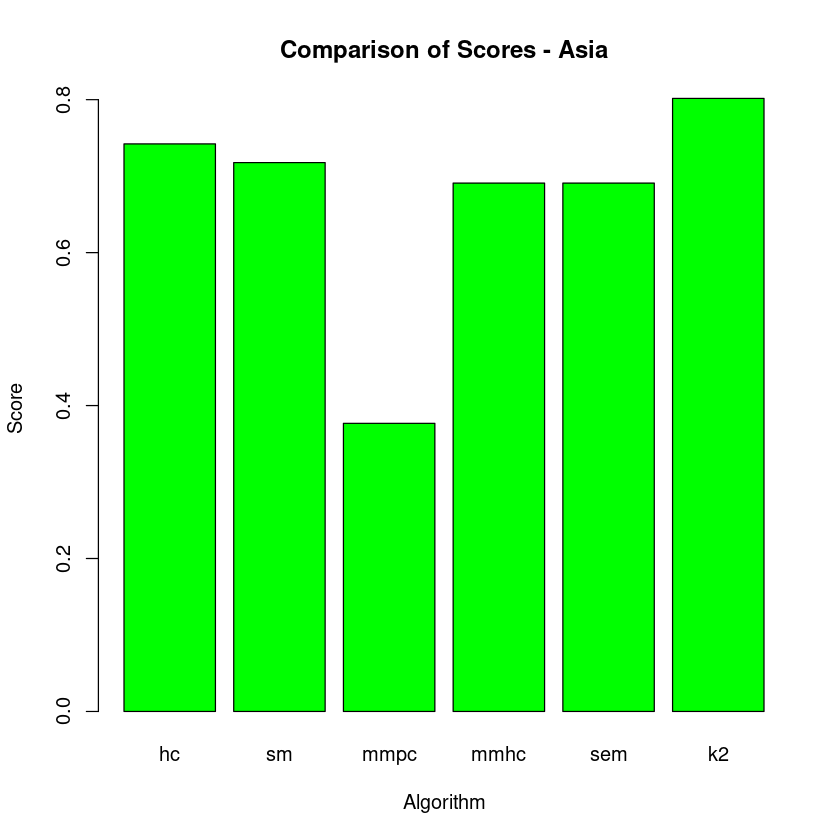

In [76]:
theorDAG <- theorDAG_asia
computed <- lapply(dag_listAsia, function(dag) compare(amat(theorDAG), amat(dag)))
computed$k2 <- compare(amat(theorDAG), amat(dag.asia.k2))
# Create a bar chart of the computed scores
barplot(unlist(computed), names.arg = names(computed), xlab = "Algorithm", ylab = "Score", main = "Comparison of Scores - Asia", col = "green")

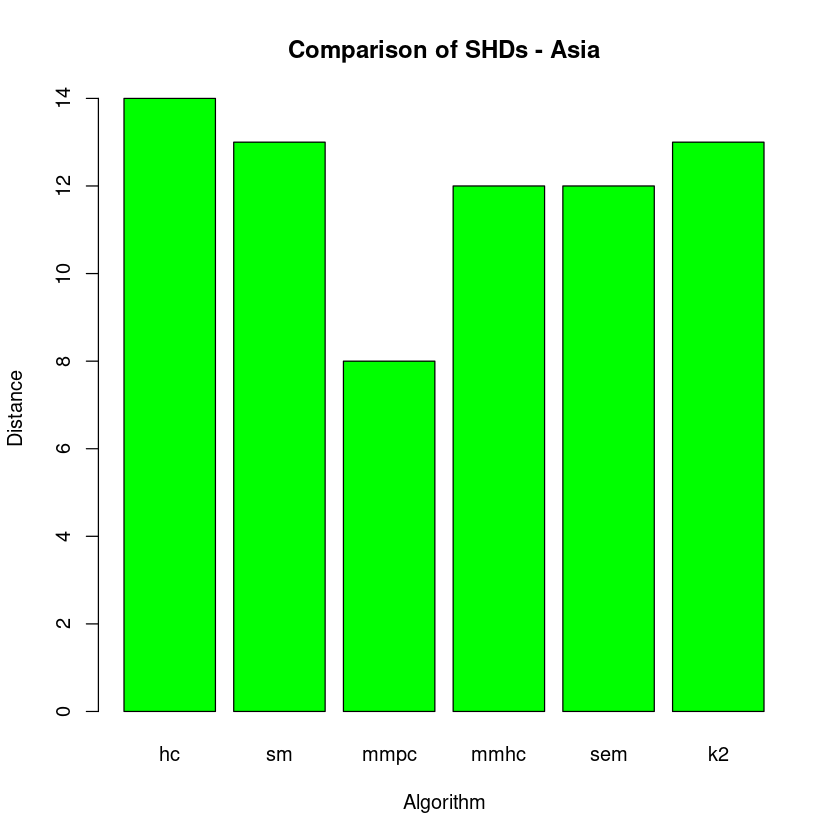

In [77]:
computed <- lapply(dag_listAsia, function(dag) computeShdSingle(theor = theorDAG, empir = dag))
computed$k2 <- computeShdSingle(theor = theorDAG, empir = dag.asia.k2)
# Create a bar chart of the computed scores
barplot(unlist(computed), names.arg = names(computed), xlab = "Algorithm", ylab = "Distance", main = "Comparison of SHDs - Asia", col = "green")

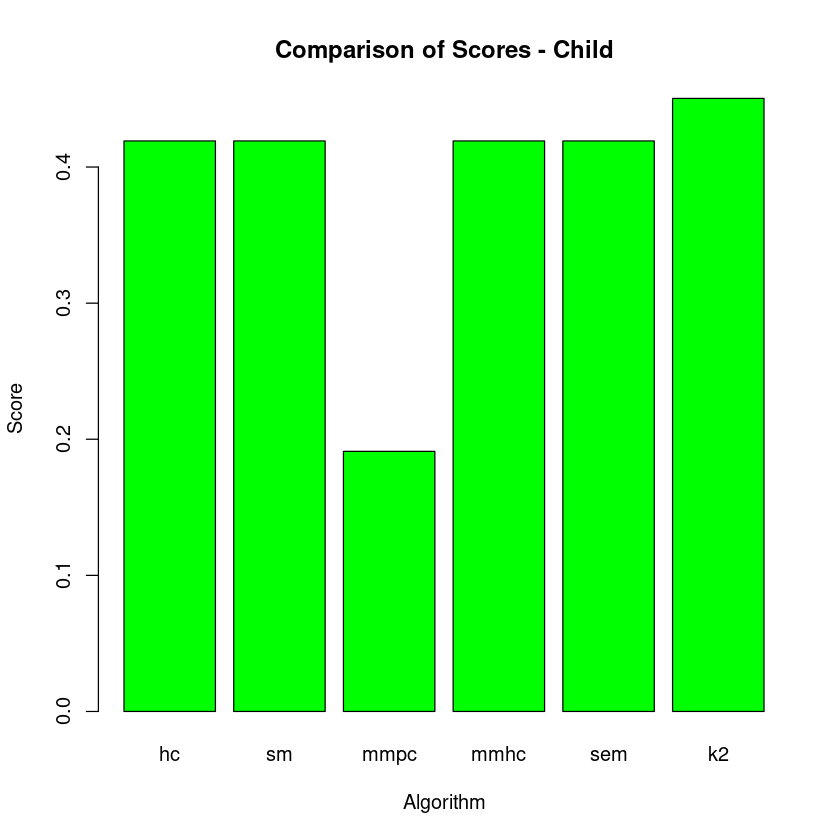

In [87]:
theorDAG <- theorDAG_child
computed <- lapply(dag_listChild, function(dag) compare(amat(theorDAG), amat(dag)))
computed$k2 <- compare(amat(theorDAG), amat(dag.child.k2))
# Create a bar chart of the computed scores
barplot(unlist(computed), names.arg = names(computed), xlab = "Algorithm", ylab = "Score", main = "Comparison of Scores - Child", col = "green")

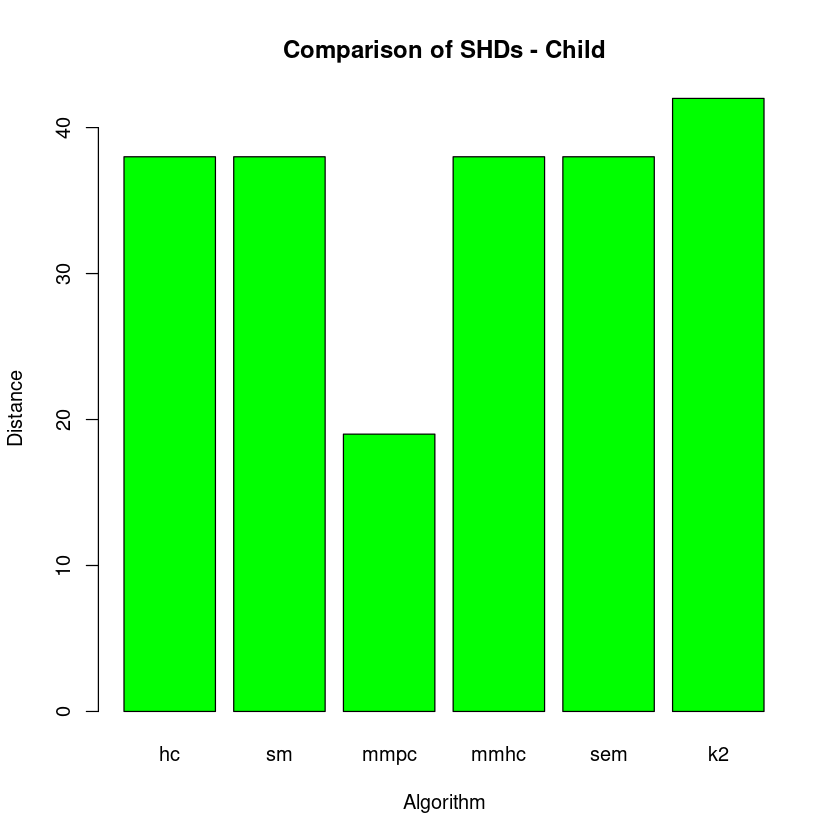

In [89]:
computed <- lapply(dag_listChild, function(dag) computeShdSingle(theor = theorDAG, empir = dag))
computed$k2 <- computeShdSingle(theor = theorDAG, empir = dag.child.k2)
# Create a bar chart of the computed scores
barplot(unlist(computed), names.arg = names(computed), xlab = "Algorithm", ylab = "Distance", main = "Comparison of SHDs - Child", col = "green")